In [22]:
import pandas as pd
import numpy as np
import multiprocessing
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import gc
from time import time
import datetime
from tqdm import tqdm_notebook
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.metrics import roc_auc_score
warnings.simplefilter('ignore')
sns.set()
%matplotlib inline
from fancyimpute import KNN
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
import json
import os
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import time

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
import lightgbm as lgb

from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

In [2]:
# Read Files
X_train = pd.read_csv('../data/output/final_X_train.csv', index_col=0)
X_test = pd.read_csv('../data/output/final_X_test.csv', index_col = 0)

y_train = pd.read_csv('../data/output/resampled_y_train.csv')['isFraud']
y_test = pd.read_csv('../data/output/y_test.csv')['isFraud']

In [3]:
X_train.shape, y_train.shape

((458224, 251), (458224,))

In [4]:
X_test.shape, y_test.shape

((118108, 251), (118108,))

## Models

#### Logistic Regression - Baseline

In [ ]:


# Train a logistic regression model on the training data
reg = LogisticRegression(
    C=1,
    solver="newton-cg", 
    penalty="l2", 
    n_jobs=-1, 
    max_iter=100,
    random_state=42
)
reg.fit(X_train, y_train)

# Predictions for In-Sample (Training) data
y_train_pred_proba = reg.predict_proba(X_train)[:, 1]
y_train_pred = (y_train_pred_proba > 0.5).astype(int)

# Predictions for Out-of-Sample (Test) data
y_test_pred_proba = reg.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_pred_proba > 0.5).astype(int)

# Metrics for IS (Training) evaluation
is_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
is_confusion = confusion_matrix(y_train, y_train_pred)
is_precision = precision_score(y_train, y_train_pred)
is_recall = recall_score(y_train, y_train_pred)
is_f1 = f1_score(y_train, y_train_pred)

# Metrics for OS (Test) evaluation
os_roc_auc = roc_auc_score(y_test, y_test_pred_proba)
os_confusion = confusion_matrix(y_test, y_test_pred)
os_precision = precision_score(y_test, y_test_pred)
os_recall = recall_score(y_test, y_test_pred)
os_f1 = f1_score(y_test, y_test_pred)

# Print IS metrics
print("In-Sample (Training) Evaluation:")
print(f"  ROC AUC: {is_roc_auc:.5f}")
print(f"  Confusion Matrix:\n{is_confusion}")
print(f"  Precision: {is_precision:.5f}")
print(f"  Recall: {is_recall:.5f}")
print(f"  F1 Score: {is_f1:.5f}")
print()

# Print OS metrics
print("Out-of-Sample (Test) Evaluation:")
print(f"  ROC AUC: {os_roc_auc:.5f}")
print(f"  Confusion Matrix:\n{os_confusion}")
print(f"  Precision: {os_precision:.5f}")
print(f"  Recall: {os_recall:.5f}")
print(f"  F1 Score: {os_f1:.5f}")


In-Sample (Training) Evaluation:
  ROC AUC: 0.86530
  Confusion Matrix:
[[311430  17276]
 [ 63145  66373]]
  Precision: 0.79347
  Recall: 0.51246
  F1 Score: 0.62273

Out-of-Sample (Test) Evaluation:
  ROC AUC: 0.82673
  Confusion Matrix:
[[104673   9371]
 [  1957   2107]]
  Precision: 0.18357
  Recall: 0.51845
  F1 Score: 0.27114


#### Random Forest

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Define a baseline Random Forest model
rf_baseline = RandomForestClassifier(
    n_estimators=100,  # Fewer trees
    max_depth=10,  # Limit tree depth for simplicity
    random_state=42,
    n_jobs=-1,  # Use all available cores
)

# Train the baseline model
rf_baseline.fit(X_train, y_train)

# Make predictions on the test set
rf_preds = rf_baseline.predict(X_test)
rf_probs = rf_baseline.predict_proba(X_test)[:, 1]  # Probabilities for ROC AUC

# Calculate evaluation metrics
conf_matrix = confusion_matrix(y_test, rf_preds)
precision = precision_score(y_test, rf_preds)
recall = recall_score(y_test, rf_preds)
f1 = f1_score(y_test, rf_preds)
roc_auc = roc_auc_score(y_test, rf_probs)

# Print evaluation metrics
print("\nBaseline Evaluation Metrics on Test Set:")
print("Confusion Matrix:")
print(conf_matrix)
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

# Optional: Display classification report
print("\nClassification Report:")
print(classification_report(y_test, rf_preds))



Baseline Evaluation Metrics on Test Set:
Confusion Matrix:
[[112593   1451]
 [  2436   1628]]
Precision: 0.53
Recall: 0.40
F1 Score: 0.46
ROC AUC: 0.88

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98    114044
           1       0.53      0.40      0.46      4064

    accuracy                           0.97    118108
   macro avg       0.75      0.69      0.72    118108
weighted avg       0.96      0.97      0.96    118108



#### XGBoost with HyperOpt

In [7]:
!pip install hyperopt


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\Jonat\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
from hyperopt import hp, tpe, fmin, Trials
from hyperopt.pyll.base import scope
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
import numpy as np
import time
import gc

def objective_xgb(params):
    time1 = time.time()
    params['max_depth'] = int(params['max_depth'])
    params['n_estimators'] = 600  # Fixed number of estimators
    params['tree_method'] = 'gpu_hist'  # Use GPU for faster training (if supported)
    params['verbosity'] = 0  # Suppress output for training

    print("\n############## New Run ################")
    print(f"params = {params}")
    
    FOLDS = 7
    skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)
    score_mean = 0

    for tr_idx, val_idx in skf.split(X_train, y_train):
        clf = XGBClassifier(**params)
        X_tr, X_vl = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]
        y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
        
        clf.fit(X_tr, y_tr)
        preds = clf.predict_proba(X_vl)[:, 1]
        score = roc_auc_score(y_vl, preds)
        score_mean += score
    
    mean_auc = score_mean / FOLDS
    print(f"Mean ROC_AUC: {mean_auc}")
    time2 = time.time() - time1
    print(f"Total Time Run: {round(time2 / 60, 2)} minutes")
    gc.collect()
    return -mean_auc

space_xgb = {
    'max_depth': scope.int(hp.quniform('max_depth', 5, 20, 1)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'gamma': hp.uniform('gamma', 0.01, 1),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'subsample': hp.uniform('subsample', 0.5, 1),
}

trials_xgb = Trials()
best_xgb = fmin(fn=objective_xgb, space=space_xgb, algo=tpe.suggest, max_evals=50, trials=trials_xgb)
print("Best parameters for XGB: ", best_xgb)


In [9]:
best_xgb = {'colsample_bytree': 0.5283564481109091, 'gamma': 0.17401636078164703, 'learning_rate': 0.06335911684228697, 'max_depth': 13.0, 'reg_alpha': 0.6708028203534311, 'reg_lambda': 0.0025597925638101565, 'subsample': 0.999083304678769}
best_xgb['max_depth'] = int(best_xgb['max_depth'])

In [29]:
import xgboost as xgb
# Make predictions on the test set
# Assuming `best_params` contains the best parameters from hyperparameter tuning.
# Train the model on the full training data
final_xgb_model = xgb.XGBClassifier(
    n_estimators=600,  # Set to the same number used during tuning
    tree_method='gpu_hist',  # Optional: Use GPU if available
    random_state=42,
    **best_xgb
)

final_xgb_model.fit(X_train, y_train)

xgb_preds = final_xgb_model.predict(X_test)
xgb_probs = final_xgb_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC AUC

# Calculate evaluation metrics
conf_matrix = confusion_matrix(y_test, xgb_preds)
precision = precision_score(y_test, xgb_preds)
recall = recall_score(y_test, xgb_preds)
f1 = f1_score(y_test, xgb_preds)
roc_auc = roc_auc_score(y_test, xgb_probs)

# Print evaluation metrics
print("\nEvaluation Metrics on Test Set:")
print("Confusion Matrix:")
print(conf_matrix)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Optional: Display classification report
print("\nClassification Report:")
print(classification_report(y_test, xgb_preds))


Evaluation Metrics on Test Set:
Confusion Matrix:
[[113609    435]
 [  2063   2001]]
Precision: 0.8214
Recall: 0.4924
F1 Score: 0.6157
ROC AUC: 0.9433

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    114044
           1       0.82      0.49      0.62      4064

    accuracy                           0.98    118108
   macro avg       0.90      0.74      0.80    118108
weighted avg       0.98      0.98      0.98    118108



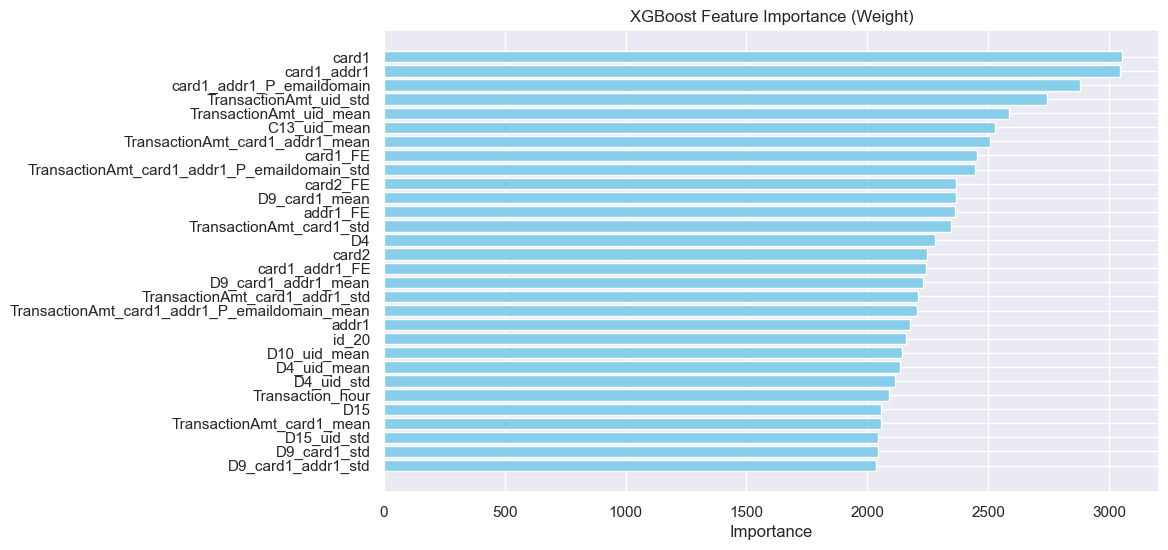

In [11]:
# Extract feature importance
xgb_feature_importance = final_xgb_model.get_booster().get_score(importance_type='weight')

# Convert to DataFrame for easier visualization
xgb_feature_importance_df = pd.DataFrame(
    list(xgb_feature_importance.items()),
    columns=['Feature', 'Importance']
).sort_values(by='Importance', ascending=False)[:30]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(xgb_feature_importance_df['Feature'], xgb_feature_importance_df['Importance'], color='skyblue')
plt.title('XGBoost Feature Importance (Weight)')
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.show()

#### LGBM - HyperOpt

In [ ]:
from lightgbm import LGBMClassifier

def objective_lgbm(params):
    time1 = time.time()
    params['max_depth'] = int(params['max_depth'])
    params['n_estimators'] = 600  # Fixed number of estimators
    params['verbosity'] = -1  # Suppress output

    print("\n############## New Run ################")
    print(f"params = {params}")
    
    FOLDS = 7
    skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)
    score_mean = 0

    for tr_idx, val_idx in skf.split(X_train, y_train):
        clf = LGBMClassifier(**params)
        X_tr, X_vl = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]
        y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
        
        clf.fit(X_tr, y_tr)
        preds = clf.predict_proba(X_vl)[:, 1]
        score = roc_auc_score(y_vl, preds)
        score_mean += score
    
    mean_auc = score_mean / FOLDS
    print(f"Mean ROC_AUC: {mean_auc}")
    time2 = time.time() - time1
    print(f"Total Time Run: {round(time2 / 60, 2)} minutes")
    gc.collect()
    return -mean_auc

space_lgbm = {
    'max_depth': scope.int(hp.quniform('max_depth', 5, 20, 1)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'feature_fraction': hp.uniform('feature_fraction', 0.5, 1),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.5, 1),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 10, 100, 5)),
    'num_leaves': scope.int(hp.quniform('num_leaves', 20, 150, 10)),
}

trials_lgbm = Trials()
best_lgbm = fmin(fn=objective_lgbm, space=space_lgbm, algo=tpe.suggest, max_evals=50, trials=trials_lgbm)
print("Best parameters for LGBM: ", best_lgbm)


In [13]:
best_lgbm = {'bagging_fraction': 0.9552500251554533, 'feature_fraction': 0.9263523598979249, 'learning_rate': 0.11302589633505723, 'max_depth': 19, 'min_child_samples': 85, 'num_leaves': 150, 'reg_alpha': 0.4547602952186245, 'reg_lambda': 0.006517479648214031}

In [28]:
# Train the model on the full training data
final_lgbm_model = lgb.LGBMClassifier(
    n_estimators=600,  # Set to the same number used during tuning
    random_state=42,
    **best_lgbm
)

final_lgbm_model.fit(X_train, y_train)

# Make predictions
lgbm_preds = final_lgbm_model.predict(X_test)
lgbm_probs = final_lgbm_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC AUC

# Calculate evaluation metrics
conf_matrix = confusion_matrix(y_test, lgbm_preds)
precision = precision_score(y_test, lgbm_preds)
recall = recall_score(y_test, lgbm_preds)
f1 = f1_score(y_test, lgbm_preds)
roc_auc = roc_auc_score(y_test, lgbm_probs)

# Print evaluation metrics
print("\nEvaluation Metrics on Test Set (LightGBM):")
print("Confusion Matrix:")
print(conf_matrix)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Optional: Display classification report
print("\nClassification Report:")
print(classification_report(y_test, lgbm_preds))

[LightGBM] [Warning] feature_fraction is set=0.9263523598979249, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9263523598979249
[LightGBM] [Warning] bagging_fraction is set=0.9552500251554533, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9552500251554533
[LightGBM] [Warning] feature_fraction is set=0.9263523598979249, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9263523598979249
[LightGBM] [Warning] bagging_fraction is set=0.9552500251554533, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9552500251554533
[LightGBM] [Info] Number of positive: 129518, number of negative: 328706
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.091520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 58797
[LightGBM] [Info] Number of data points in the train set: 458224

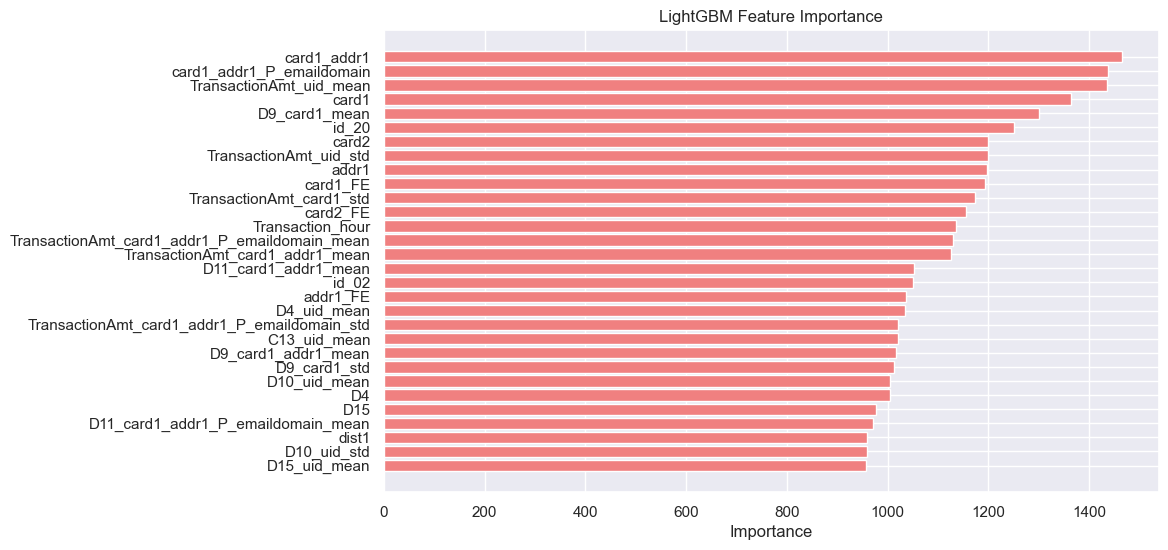

In [15]:
# Extract feature importance
lgbm_feature_importance = final_lgbm_model.feature_importances_

# Convert to DataFrame
lgbm_feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': lgbm_feature_importance
}).sort_values(by='Importance', ascending=False)[:30]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(lgbm_feature_importance_df['Feature'], lgbm_feature_importance_df['Importance'], color='lightcoral')
plt.title('LightGBM Feature Importance')
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.show()

#### Stacking Classifier

In [25]:
# Define the meta-model
meta_model = LogisticRegression(random_state=42)

# Generate predictions for the meta-model
base_preds = {
    "xgb": final_xgb_model.predict_proba(X_train)[:, 1],
    "lgbm": final_lgbm_model.predict_proba(X_train)[:, 1],
    # "rf": rf_baseline.predict_proba(X_train)[:, 1],
}

# Combine predictions into a new dataset
meta_features = np.column_stack(list(base_preds.values()))

# Train the meta-model
meta_model.fit(meta_features, y_train)

# Generate predictions on test data
test_base_preds = {
    "xgb": final_xgb_model.predict_proba(X_test)[:, 1],
    "lgbm": final_lgbm_model.predict_proba(X_test)[:, 1],
    # "rf": rf_baseline.predict_proba(X_test)[:, 1],
}
meta_test_features = np.column_stack(list(test_base_preds.values()))

# Get final predictions and probabilities from the meta-model
final_predictions = meta_model.predict(meta_test_features)
final_probabilities = meta_model.predict_proba(meta_test_features)[:, 1]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, final_predictions)
precision = precision_score(y_test, final_predictions)
recall = recall_score(y_test, final_predictions)
f1 = f1_score(y_test, final_predictions)
roc_auc = roc_auc_score(y_test, final_probabilities)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, final_predictions)

# Print the results
print("\nEvaluation Metrics for Stacking Model on Test Set:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

print("\nConfusion Matrix:")
print(conf_matrix)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, final_predictions))


[LightGBM] [Warning] feature_fraction is set=0.9263523598979249, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9263523598979249
[LightGBM] [Warning] bagging_fraction is set=0.9552500251554533, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9552500251554533
[LightGBM] [Warning] feature_fraction is set=0.9263523598979249, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9263523598979249
[LightGBM] [Warning] bagging_fraction is set=0.9552500251554533, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9552500251554533

Evaluation Metrics for Stacking Model on Test Set:
Accuracy: 0.9787
Precision: 0.8112
Recall: 0.4958
F1-Score: 0.6155
ROC-AUC Score: 0.9446

Confusion Matrix:
[[113575    469]
 [  2049   2015]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    114044
           1       0.81      0.50      0.62      4064

    accuracy   

#### Voting Classifier

In [27]:
from sklearn.ensemble import VotingClassifier

# Define the voting classifier with pre-trained models
voting_model = VotingClassifier(
    estimators=[
        ('xgb', final_xgb_model),  # Pre-trained XGBoost model
        ('lgbm', final_lgbm_model),  # Pre-trained LightGBM model
        # ('rf', rf_baseline)  # Pre-trained Random Forest baseline model
    ],
    voting='soft',  # Use 'soft' voting for probability-based aggregation
    n_jobs=-1
)

# Train the voting classifier
voting_model.fit(X_train, y_train)

# Predictions and evaluation
voting_preds = voting_model.predict(X_test)
voting_probs = voting_model.predict_proba(X_test)[:, 1]

# Metrics
conf_matrix = confusion_matrix(y_test, voting_preds)
precision = precision_score(y_test, voting_preds)
recall = recall_score(y_test, voting_preds)
f1 = f1_score(y_test, voting_preds)
roc_auc = roc_auc_score(y_test, voting_probs)

print("\nVoting Classifier Evaluation Metrics:")
print("Confusion Matrix:")
print(conf_matrix)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")


[LightGBM] [Warning] feature_fraction is set=0.9263523598979249, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9263523598979249
[LightGBM] [Warning] bagging_fraction is set=0.9552500251554533, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9552500251554533
[LightGBM] [Warning] feature_fraction is set=0.9263523598979249, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9263523598979249
[LightGBM] [Warning] bagging_fraction is set=0.9552500251554533, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9552500251554533

Voting Classifier Evaluation Metrics:
Confusion Matrix:
[[113565    479]
 [  2045   2019]]
Precision: 0.8082
Recall: 0.4968
F1 Score: 0.6154
ROC AUC: 0.9446
